Время расчёта для N=60: 5.36 c
Периоды для точек при N=60: [np.float64(75.0), np.float64(75.0), None, np.float64(37.5)]


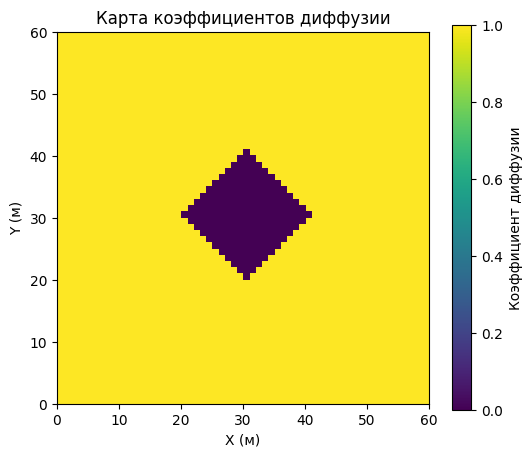

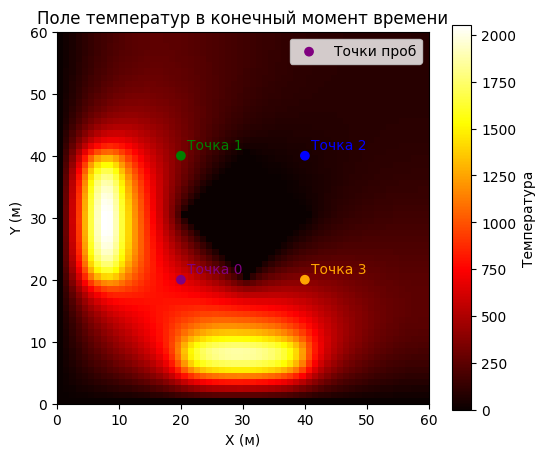

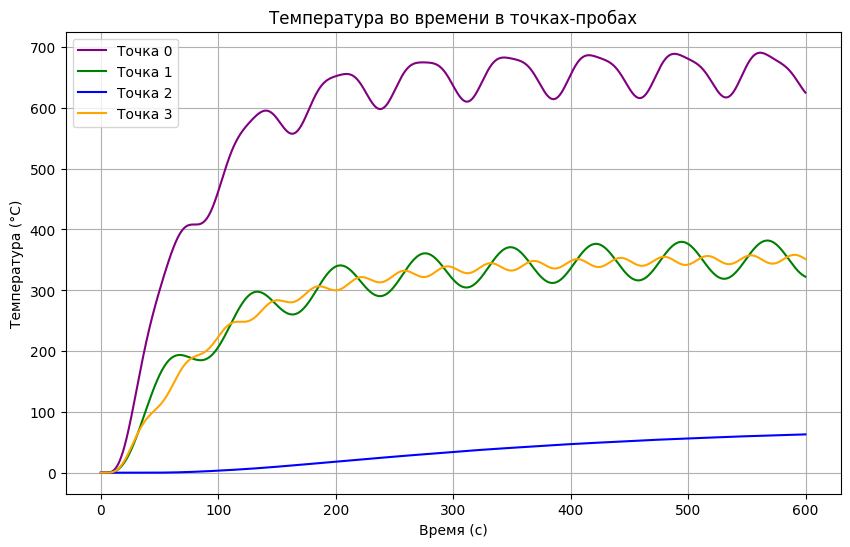

Время расчёта для N=120: 1.04 c
Периоды для точек при N=120: [np.float64(75.0), np.float64(75.0), None, np.float64(37.5)]


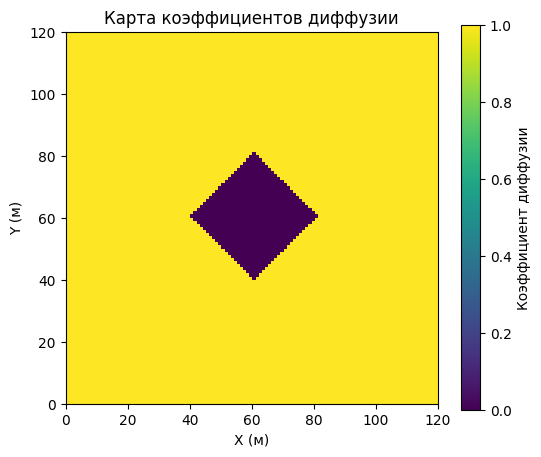

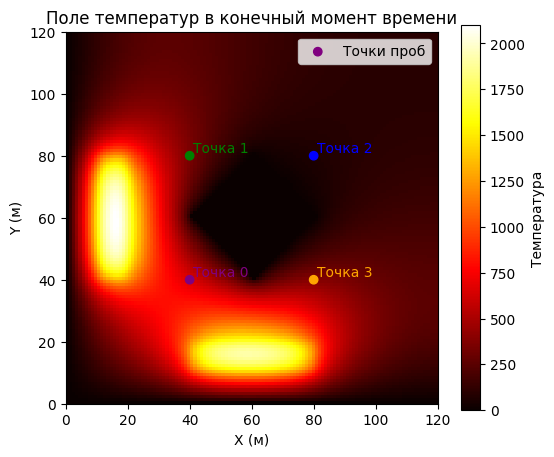

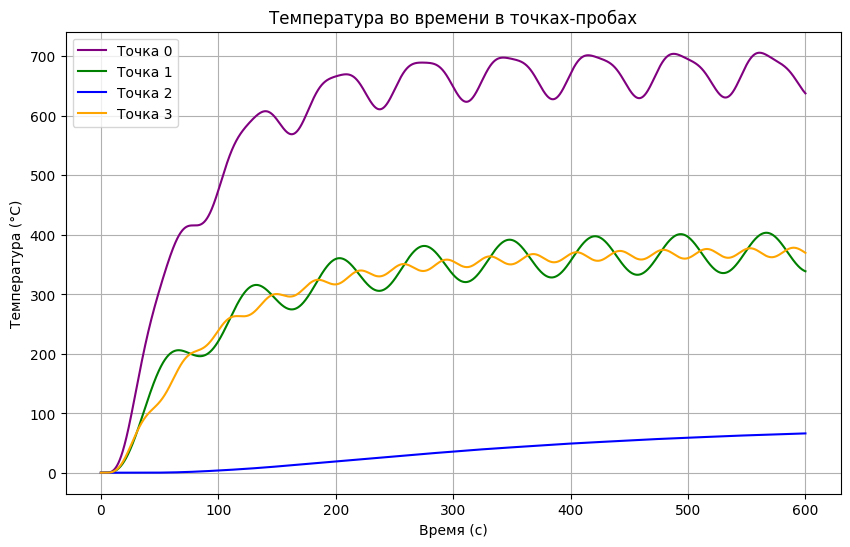

Время расчёта для N=240: 6.17 c
Периоды для точек при N=240: [np.float64(75.0), np.float64(75.0), None, np.float64(37.5)]


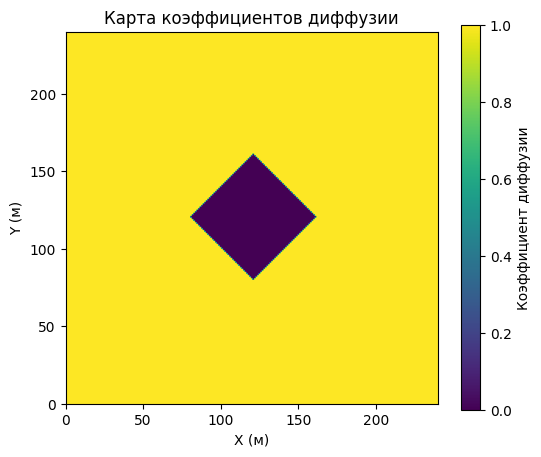

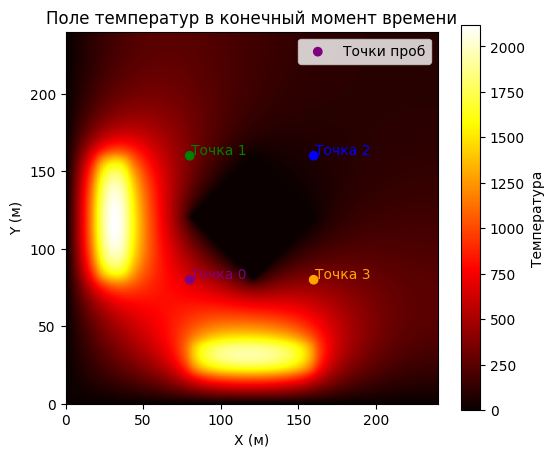

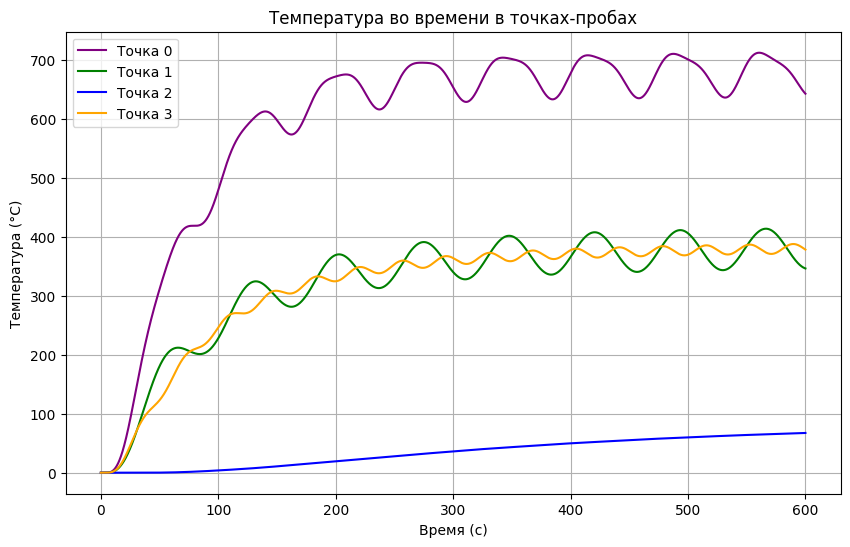

Время расчёта для N=480: 187.46 c
Периоды для точек при N=480: [np.float64(75.0), np.float64(75.0), None, np.float64(37.5)]


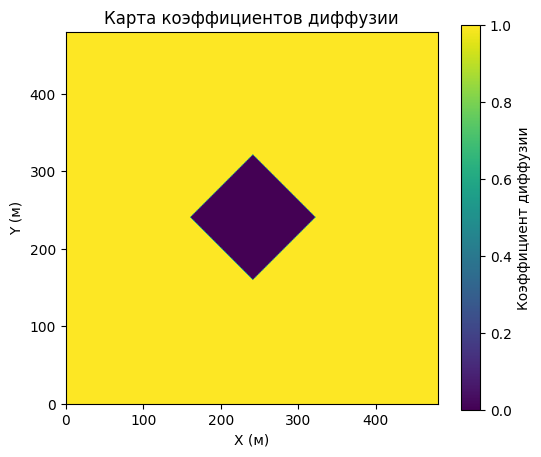

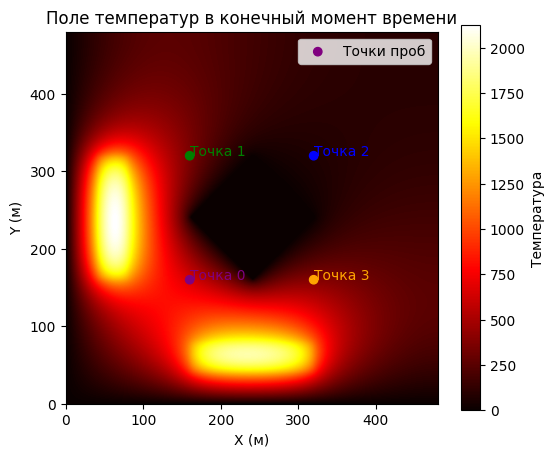

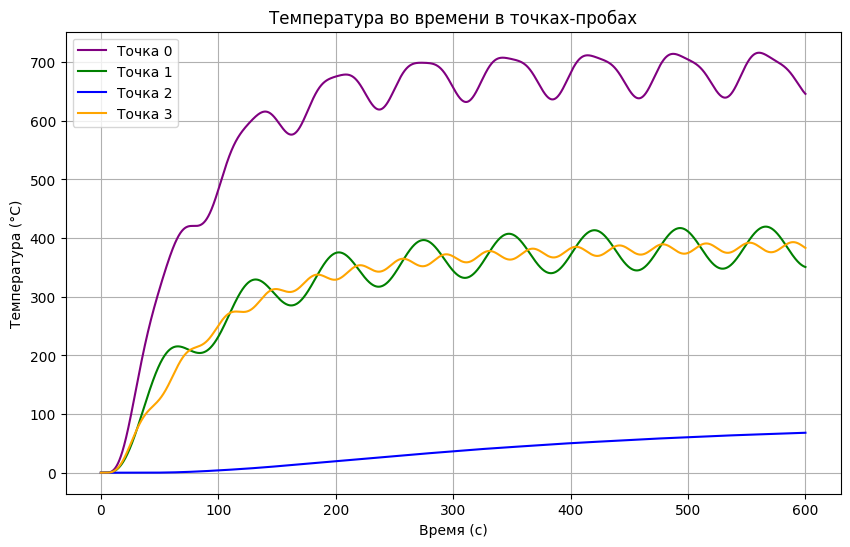

Время расчёта для N=960: 3345.91 c
Периоды для точек при N=960: [np.float64(75.0), np.float64(75.0), None, np.float64(37.5)]


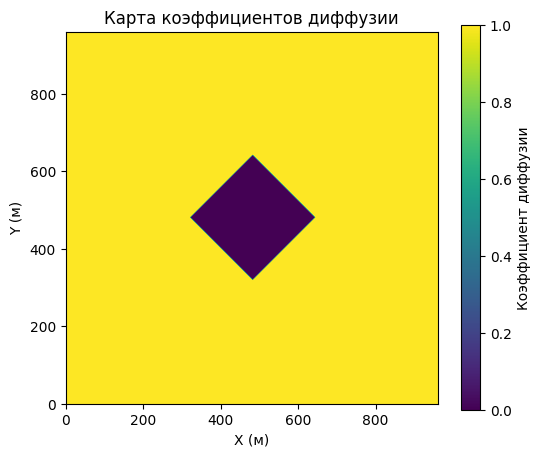

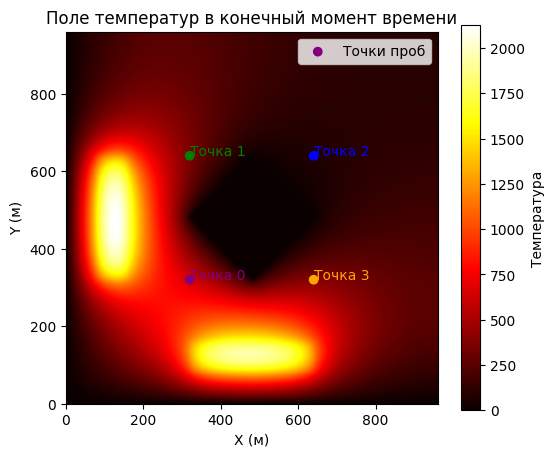

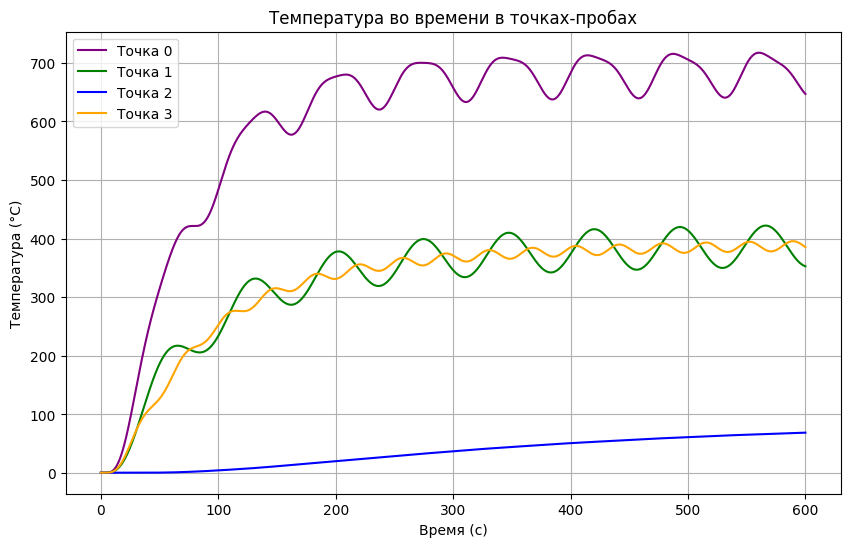

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import time
from numba import njit, prange

# === Утилиты ===

@njit
def inside_diamond(i, j, L, dx):
    """
    Проверяет, находится ли точка (i, j) внутри ромба.

    Ромб имеет вершины: (30, 20), (40, 30), (30, 40), (20, 30)
    в физических координатах. Уравнение ромба:
    |x - 30| + |y - 30| <= 10 (центр в точке (30, 30)).

    Args:
        i (int): Индекс по оси X.
        j (int): Индекс по оси Y.
        L (float): Размер области моделирования (длина одной стороны).
        dx (float): Пространственный шаг сетки.

    Returns:
        bool: True, если точка внутри ромба, иначе False.
    """
    x = i * dx
    y = j * dx
    return abs(x - L / 2) + abs(y - L / 2) <= L / 6

# === Основные вычислительные функции ===

@njit(parallel=True)
def boundary_conditions(T):
    """
    Реализует граничные условия абсолютной теплоизоляции с распараллеливанием.
    Температура на краях области устанавливается равной температуре
    соседних узлов внутри области для
    x=60
    y=60
    Фиксированная температура 0 для
    x=0
    y=0

    Args:
        T (np.ndarray): Массив температур (3D: итерация, X, Y).
    """
    for j in prange(T.shape[2]):
        T[:, 0, j] = 0
        T[:, -1, j] = T[:, -2, j]
    for i in prange(T.shape[1]):
        T[:, i, 0] = 0
        T[:, i, -1] = T[:, i, -2]

@njit(parallel=True)
def diffuse_step_full(it, T, dx, dt, Dij):
    """
    Выполняет один шаг диффузии с распараллеливанием.

    Args:
        it (int): Номер текущей итерации.
        T (np.ndarray): Массив температур (3D: итерация, X, Y).
        dx (float): Пространственный шаг сетки.
        dt (float): Шаг по времени.
        Dij (np.ndarray): Коэффициенты диффузии в узлах сетки.
    """
    prev = it % 2
    cur = (it + 1) % 2
    g = dt * Dij[1:-1, 1:-1] / dx**2

    for i in prange(1, T.shape[1] - 1):
        for j in range(1, T.shape[2] - 1):
            T[cur, i, j] = T[prev, i, j] + g[i - 1, j - 1] * (
                T[prev, i - 1, j] + T[prev, i + 1, j] +
                T[prev, i, j - 1] + T[prev, i, j + 1] -
                4 * T[prev, i, j]
            )

@njit(parallel=True)
def heat_source(T, dx, dt, t, p1, p2, theta0, theta1):
    """
    Добавляет тепловой поток в области нагревателей с распараллеливанием.

    Args:
        T (np.ndarray): Массив температур (3D: итерация, X, Y).
        dx (float): Пространственный шаг сетки.
        dt (float): Шаг по времени.
        t (float): Текущее время.
        p1 (float): Амплитуда колебаний первого нагревателя.
        p2 (float): Амплитуда колебаний второго нагревателя.
        theta0 (float): Период колебаний первого нагревателя.
        theta1 (float): Период колебаний второго нагревателя.
    """
    q0 = p1 * (np.sin(2 * np.pi / theta0 * t) + 1)
    q1 = p2 * (np.sin(2 * np.pi / theta1 * t) + 1)

    h1, w1 = int(5 / dx), int(20 / dx)
    x1, y1 = int(20 / dx), int(5 / dx)
    h2, w2 = int(20 / dx), int(5 / dx)
    x2, y2 = int(5 / dx), int(20 / dx)

    for i in prange(T.shape[1]):
        for j in range(T.shape[2]):
            if y1 <= i < y1 + h1 and x1 <= j < x1 + w1:
                T[:, i, j] += q0 * dt
            elif y2 <= i < y2 + h2 and x2 <= j < x2 + w2:
                T[:, i, j] += q1 * dt

# === Основная функция моделирования ===

@njit(parallel=True)
def Schitalka(N, it_max, T, dx, dt, Dij, y0_p, x0_p, y1_p, x1_p, y2_p, x2_p, y3_p, x3_p, p_vals, t):
    """
    Основная функция моделирования с распараллеливанием.

    Args:
        N (int): Число узлов сетки.
        it_max (int): Число итераций.
        T (np.ndarray): Массив температур (3D: итерация, X, Y).
        dx (float): Пространственный шаг сетки.
        dt (float): Шаг по времени.
        Dij (np.ndarray): Коэффициенты диффузии.
        y0_p, x0_p, ... (int): Координаты точек-проб.
        p_vals (np.ndarray): Массив для записи значений в точках-пробах.
        t (np.ndarray): Массив времени.

    Returns:
        tuple: Обновленные массивы T, p_vals, t.
    """
    for it in range(it_max):
        heat_source(T, dx, dt, it * dt, 100, 100, 37, 73)
        boundary_conditions(T)
        diffuse_step_full(it, T, dx, dt, Dij)

        for idx in prange(4):
            if idx == 0:
                p_vals[0, it] = T[it % 2, y0_p, x0_p]
            elif idx == 1:
                p_vals[1, it] = T[it % 2, y1_p, x1_p]
            elif idx == 2:
                p_vals[2, it] = T[it % 2, y2_p, x2_p]
            elif idx == 3:
                p_vals[3, it] = T[it % 2, y3_p, x3_p]

        t[it] = it * dt

    return T, p_vals, t

def find_dominant_period(signal, dt):
    """
    Находит доминирующий период колебаний в сигнале методом БПФ.

    Args:
        signal (np.ndarray): Одномерный массив значений сигнала.
        dt (float): Шаг по времени.

    Returns:
        float: Период доминирующей частоты (если найдена), иначе None.
    """
    # Применение БПФ
    FFT = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), d=dt)
    amplitude = np.abs(FFT)

    # Поиск пиков амплитуды
    peaks, _ = find_peaks(amplitude, height=1e-3)
    if len(peaks) == 0:
        return None  # Если пиков нет, возвращаем None

    # Выбор частоты с максимальной амплитудой (исключая нулевую частоту)
    main_peak = peaks[np.argmax(amplitude[peaks])]
    freq_main = freqs[main_peak]
    if freq_main != 0:
        return 1.0 / freq_main  # Период = 1 / Частота
    return None

# === Основные параметры ===
L = 60  # Длина области моделирования (м)
N_values = [60, 120, 240, 480, 960]  # Число узлов сетки для тестов
D0 = 1  # Коэффициент диффузии в основной области (м^2/с)
D1 = 0.01  # Коэффициент диффузии внутри ромба (м^2/с)
p1 = p2 = 100  # Максимальная мощность нагревателей
theta0 = 37  # Период колебаний источника 1 (с)
theta1 = 73  # Период колебаний источника 2 (с)
C = 0.2  # Число Куранта (условие устойчивости)
tmax = 600.0  # Время моделирования (с)

# === Цикл моделирования ===

for N in N_values:
    dx = L / N
    dt = C * dx**2 / D0
    it_max = int(tmax / dt)
    T = np.zeros((2, N, N))

    x0_p, y0_p = int(20 / dx), int(20 / dx)
    x1_p, y1_p = int(20 / dx), int(40 / dx)
    x2_p, y2_p = int(40 / dx), int(40 / dx)
    x3_p, y3_p = int(40 / dx), int(20 / dx)

    Dij = np.full((N, N), D0)
    for i in range(N):
        for j in range(N):
            if inside_diamond(i, j, L, dx):
                Dij[i, j] = D1

    # Инициализация массивов для записи данных
    p_vals = np.zeros((4, it_max))
    t = np.zeros(it_max)

    # Расчёт
    start_time = time.time()

    T, p_vals, t = Schitalka(N, it_max, T, dx, dt, Dij, y0_p, x0_p, y1_p, x1_p , y2_p, x2_p, y3_p, x3_p, p_vals, t)

    end_time = time.time()
    print("Время расчёта для N={}: {:.2f} c".format(N, end_time - start_time))

    # Анализ периодов колебаний
    periods = [find_dominant_period(p_vals[i], dt) for i in range(4)]
    print("Периоды для точек при N={}: {}".format(N, periods))

    # Сохранение результатов
    np.save(f"T_save{N}.npy", T)
    np.save(f"p_vals_save{N}.npy", p_vals)
    np.save(f"time_save{N}.npy", t)
    np.save(f"Dij_save{N}.npy", Dij)

    # Загружаем сохраненные данные
    T_load = np.load(f"T_save{N}.npy")
    p_vals_load = np.load(f"p_vals_save{N}.npy")
    t_load = np.load(f"time_save{N}.npy")
    Dij_load = np.load(f"Dij_save{N}.npy")

    # === Визуализация ===

    # Цвета для точек
    colors = ['Purple', 'green', 'blue', 'orange']

    # Карта коэффициентов диффузии
    plt.figure(figsize=(6, 5))
    plt.imshow(Dij_load,
               extent=[0, N, 0, N],
               origin='lower',
               cmap='viridis')
    plt.colorbar(label='Коэффициент диффузии')
    plt.title('Карта коэффициентов диффузии')
    plt.xlabel('X (м)')
    plt.ylabel('Y (м)')
    plt.show()

    # Поле температур в конечный момент
    plt.figure(figsize=(6, 5))
    plt.imshow(T_load[0], extent=[0, N, 0, N], origin='lower', cmap='hot')
    plt.colorbar(label='Температура')
    plt.title('Поле температур в конечный момент времени')
    plt.xlabel('X (м)')
    plt.ylabel('Y (м)')
    plt.scatter([int(20/dx), int(20/dx), int(40/dx), int(40/dx)],
                [int(20/dx), int(40/dx), int(40/dx), int(20/dx)],
                c=colors,
                label='Точки проб')
    for i, color in enumerate(colors):
        plt.text([int(20/dx), int(20/dx), int(40/dx), int(40/dx)][i] + 1,
                 [int(20/dx), int(40/dx), int(40/dx), int(20/dx)][i] + 1,
                 f'Точка {i}',
                 color=color)
    plt.legend()
    plt.show()
    t_load=np.sort(t_load)

    # Температура во времени в точках-пробах
    plt.figure(figsize=(10, 6))
    p_val = p_vals_load[0]
    for i, p_val in enumerate(p_vals_load):
        plt.plot(t_load, p_val, label=f'Точка {i}', color=colors[i])
    plt.title('Температура во времени в точках-пробах')
    plt.xlabel('Время (с)')
    plt.ylabel('Температура (°C)')
    plt.legend()
    plt.grid()
    plt.show()
